# DGL-LifeSciによる分子特性予測

DGL-LifeSciは、グラフニューラルネットワーク（GNN）をライフサイエンスの様々な問題に適用するためのDGLベースのパッケージです。本デモでは、分子特性予測のためのGNNを開発します。

インストール方法については、 [[Github repo]](https://github.com/awslabs/dgl-lifesci)を参照してください。

In [3]:
!pip install dgl
!pip install dgllife
!conda install -c rdkit -y rdkit==2018.09.3

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



## Section 1: グラフの構築

GNNを分子に適用するための最初のステップは、分子をグラフに変換することです。最も直感的には、ノードが原子(atom)、エッジが原子間の結合(bond)に対応する分子グラフを構築することになります。以下のコードでは、SMILES（simplified molecular-input line-entry system）文字列からRDKitを用いて分子グラフをプロットしています。

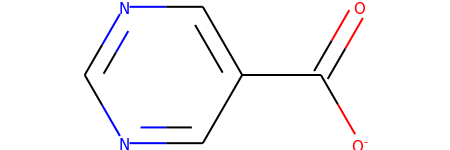

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True
smiles = 'c1ncncc1C(=O)[O-]'
mol = Chem.MolFromSmiles('c1ncncc1C(=O)[O-]')
mol

DGL-LifeSciは、RDKitの分子オブジェクトを、対応する分子グラフを表すDGLGraphに変換するための `MolToBigraph`モジュールを提供します。ノードの数は原子の数と同じです。グラフは双方向性であり、$(i, j)$と$(j, i)$は異なる辺であることを意味するので、辺の数は結合の数の2倍になります。

In [4]:
from dgllife.utils import MolToBigraph

mol_to_g = MolToBigraph()
g = mol_to_g(mol)
print(g)
assert g.num_nodes() == mol.GetNumAtoms()
assert g.num_edges() == 2 * mol.GetNumBonds()

Using backend: pytorch


Graph(num_nodes=9, num_edges=18,
      ndata_schemes={}
      edata_schemes={})


特に原子の3次元座標が利用可能な場合、半径グラフ(radius graph)やKNN（k近傍）グラフなどがよく利用されています。DGL-LifeSciのグラフ構築法の一覧は、https://lifesci.dgl.ai/api/utils.mols.html#graph-construction を参照してください。

## Section 2: 特徴量化(Featurization)

GNNがうまく機能するためには、構造情報と特徴情報の両方が必要です。従って、グラフの入力ノードやエッジの特徴を準備することは重要なステップです。

分子グラフの場合、ノードの特徴として原子タイプ/原子番号、結合の特徴として結合の種類などの情報を考慮するのが一般的です。Atom Featurizerの例を以下に示します。

In [5]:
import torch

def atom_mass(atom):
    """
    atom: RDKit atom instance
    """
    return [atom.GetMass() * 0.01]

atom = mol.GetAtomWithIdx(0)
print(atom_mass(atom))

[0.12011]


DGL-LifeSciは原子と結合に関するfeatureizerをビルトインしており、その一覧はhttps://lifesci.dgl.ai/api/utils.mols.html#featurization-for-nodes で参照できます。
また、複数のfeatureizerを組み合わせることもよくありますが、その場合は `ConcatFeaturizer` が役に立ちます。

In [6]:
from dgllife.utils import ConcatFeaturizer, atom_formal_charge


atom_featurizer = ConcatFeaturizer([atom_mass, atom_formal_charge])
print(atom_featurizer(atom))

[0.12011, 0]


DGL-LifeSciは、分子内のすべての原子に特徴量化を適用するための`BaseAtomFeaturizer`モジュールと、分子内のすべての結合に特徴づけを適用するための`BaseBondFeaturizer`モジュールを提供しています。

In [7]:
from dgllife.utils import BaseAtomFeaturizer

mol_atom_featurizer = BaseAtomFeaturizer({'feat': atom_featurizer})
print('feat size:', mol_atom_featurizer.feat_size())
print(mol_atom_featurizer(mol))

feat size: 2
{'feat': tensor([[ 0.1201,  0.0000],
        [ 0.1401,  0.0000],
        [ 0.1201,  0.0000],
        [ 0.1401,  0.0000],
        [ 0.1201,  0.0000],
        [ 0.1201,  0.0000],
        [ 0.1201,  0.0000],
        [ 0.1600,  0.0000],
        [ 0.1600, -1.0000]])}


## Section 3: データセットの準備

DGL-LifeSciでは、データセットのロードに広く使われているCSV（Comma-Sparated Values）形式を採用しています。デモでは、まずCSV形式のデータファイルをダウンロードします。

In [8]:
from dgl.data.utils import download, _get_dgl_url, extract_archive

url = 'dataset/FreeSolv.zip'
data_path = 'FreeSolv.zip'
download(_get_dgl_url(url), path=data_path)
extract_archive(data_path, './FreeSolv')

Extracting file to ./FreeSolv


CSVファイルには、SMILES文字列の列（下記ファイルではsmiles）と、プロパティの列（下記ファイルではexptとcalc）が1つまたは複数あることが必要です。ここでexptとは実験値、calcとは計算値を表します。

In [9]:
import pandas as pd

df = pd.read_csv('FreeSolv/SAMPL.csv')
df.head()

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


DGL-LifeSciでは、CSVデータファイルをロードし、グラフの構築と特徴量化を行うための `MoleculeCSVDataset`を提供しています。

In [11]:
from dgllife.data import MoleculeCSVDataset
from dgllife.utils import AttentiveFPAtomFeaturizer, AttentiveFPBondFeaturizer

node_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='feat')
edge_featurizer = AttentiveFPBondFeaturizer(bond_data_field='feat')
dataset = MoleculeCSVDataset(df, 
                             node_featurizer=node_featurizer,
                             edge_featurizer=edge_featurizer,
                             smiles_column='smiles',
                             task_names=['expt'],
                             cache_file_path='dglgraph.bin')
print('dataset size:', len(dataset))
print(dataset[0])

Processing dgl graphs from scratch...
dataset size: 642
('CN(C)C(=O)c1ccc(cc1)OC', Graph(num_nodes=13, num_edges=26,
      ndata_schemes={'feat': Scheme(shape=(39,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(10,), dtype=torch.float32)}), tensor([-11.0100]), tensor([1.]))


## Section 4: トレーニング

### Dataset分割

まず、データセットをトレーニング、バリデーション、テストのサブセットに分割する必要があります。これらは、分子をBemis-Murcko Scaffoldsに基づいてグループ化され分割されるものです。こうすることで、異なるサブセット内の分子がより構造的に異なることを促し、現実世界の分布外問題に類似すると考えられています。

In [12]:
from dgllife.utils import ScaffoldSplitter

train_set, val_set, test_set = ScaffoldSplitter.train_val_test_split(
    dataset, frac_train=0.8, frac_val=0.1, 
    frac_test=0.1, scaffold_func='smiles')

Start initializing RDKit molecule instances...
Start computing Bemis-Murcko scaffolds.


### Data Loaderの定義

In [13]:
from torch.utils.data import DataLoader

def collate_molgraphs(data):
    smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    labels = torch.stack(labels, dim=0)
    masks = torch.stack(masks, dim=0)

    return smiles, bg, labels, masks

batch_size = 128
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, 
                          shuffle=True, collate_fn=collate_molgraphs)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size,
                        collate_fn=collate_molgraphs)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size,
                         collate_fn=collate_molgraphs)

### モデル初期化

In [14]:
import torch.nn as nn
from dgllife.model import AttentiveFPPredictor
from torch.optim import Adam

model = AttentiveFPPredictor(
    node_feat_size=node_featurizer.feat_size(),
    edge_feat_size=edge_featurizer.feat_size(),
    n_tasks=dataset.n_tasks
)
loss_criterion = nn.SmoothL1Loss(reduction='none')
optimizer = Adam(model.parameters(), lr=3e-4)

### Training & Evaluation

In [ ]:
import dgl
import numpy as np
from dgllife.utils import Meter

def run_a_train_epoch(model, data_loader, loss_criterion, optimizer):
    model.train()
    train_meter = Meter()
    for _, batch_data in enumerate(data_loader):
        smiles, bg, labels, masks = batch_data
        if len(smiles) == 1:
            # Avoid potential issues with batch normalization
            continue
        
        pred = model(bg, bg.ndata['feat'], bg.edata['feat'])
        loss = (loss_criterion(pred, labels) * (masks != 0).float()).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_meter.update(pred, labels, masks)
    return np.mean(train_meter.compute_metric('r2'))

def run_an_eval_epoch(model, data_loader):
    model.eval()
    eval_meter = Meter()
    for _, batch_data in enumerate(data_loader):
        smiles, bg, labels, masks = batch_data
        pred = model(bg, bg.ndata['feat'], bg.edata['feat'])
        eval_meter.update(pred, labels, masks)
    return np.mean(eval_meter.compute_metric('r2'))

for epoch in range(100):
    train_r2 = run_a_train_epoch(model, train_loader, loss_criterion, optimizer)
    val_r2 = run_an_eval_epoch(model, val_loader)
    print('epoch {:d} | train r2 {:.4f} | val r2 {:.4f}'.format(epoch, train_r2, val_r2))
test_r2 = run_an_eval_epoch(model, test_loader)
print('test r2 {:.4f}'.format(test_r2))

[2022-12-15 04:00:50.640 pytorch-1-6-cpu-py36--ml-t3-medium-e161cdcbc257f26c3e80f094dd8d:25494 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-15 04:00:50.792 pytorch-1-6-cpu-py36--ml-t3-medium-e161cdcbc257f26c3e80f094dd8d:25494 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
epoch 0 | train r2 0.0120 | val r2 0.0404
epoch 1 | train r2 0.0596 | val r2 0.0445
epoch 2 | train r2 0.0683 | val r2 0.0463
epoch 3 | train r2 0.1041 | val r2 0.0516
epoch 4 | train r2 0.1385 | val r2 0.0590
epoch 5 | train r2 0.1472 | val r2 0.0663
epoch 6 | train r2 0.1616 | val r2 0.0738
epoch 7 | train r2 0.1772 | val r2 0.0827
epoch 8 | train r2 0.1795 | val r2 0.0921
epoch 9 | train r2 0.1938 | val r2 0.1005
epoch 10 | train r2 0.2051 | val r2 0.1089
epoch 11 | train r2 0.2165 | val r2 0.1169
epoch 12 | train r2 0.2283 | val r2 0.1264
epoch 13 | train r2 0.2391 | val r2 0.1376
epoch 14 | train r2 0.2486 | val r2 0.1

一度学習したモデルを保存しておけば、必要に応じて他の分子に適用することができます。

1-4項は、ここでのコマンドラインインターフェイスのサブセットです。 [here](https://github.com/awslabs/dgl-lifesci/tree/master/examples/property_prediction/csv_data_configuration).

## Section 5: Attention Visualization

AttentiveFPはアテンションベースのGNNです。ここでは、ある分子に対する学習済みモデルのAttentionを取得し、プロットします。これにより、今回のモデルが、入力のどこを重視して予測したかを把握することができます。

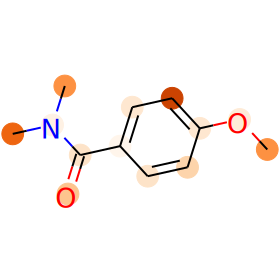

In [17]:
import matplotlib
import matplotlib.cm as cm

from IPython.display import SVG, display
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

smiles, g, _, _ = dataset[0]
_, atom_weights = model(g, g.ndata['feat'], g.edata['feat'], get_node_weight=True)
# atom_weights is a list of length 2
# we use the second suite of atom weights for visualization in this demo
atom_weights = atom_weights[-1]

# min-max normalization to make it easier to distinguish attention values
min_value = torch.min(atom_weights)
max_value = torch.max(atom_weights)
atom_weights = (atom_weights - min_value) / (max_value - min_value)

# Conver the weights to atom colors
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.28)
cmap = cm.get_cmap('Oranges')
plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) 
               for i in range(g.num_nodes())}

mol = Chem.MolFromSmiles(smiles)
rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(280,280)
drawer.SetFontSize(1)
op = drawer.drawOptions()
    
mol = rdMolDraw2D.PrepareMolForDrawing(mol)
drawer.DrawMolecule(mol, highlightAtoms=range(g.num_nodes()),highlightBonds=[],
                    highlightAtomColors=atom_colors)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
svg = svg.replace('svg:','')
display(SVG(svg))